Task objectives:

- Use the corpus from exercise no. 1.
- Use SpaCy tokenizer API to tokenize the text in the documents.
- Compute frequency list for each of the processed files.
- Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words appearing in the corpus.
- Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.
- Compute nDCG@10 for the distorted queris, using the same approach as in lab 2. This result will be the baseline for the other methods.
- Install Morfeusz (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary. Only these words should be corected in the next step.
- Use Levenshtein distance and the frequency list, to determine the most probable correction of the words in the queries that were identified as invalid. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)
- Compute nDCG@10 for your implementation of the spelling correction method.
- Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.
- Compare the results of baseline with the 2 implemented methods. Take into account the nDCG score and the performance of the methods.

In [1]:
%%capture
!pip install elasticsearch==8.8.0

In [2]:
%%bash

rm -rf elasticsearch*
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.8.0-linux-x86_64.tar.gz
tar -xzf elasticsearch-8.8.0-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-8.8.0/
umount /sys/fs/cgroup
apt install cgroup-tools

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcgroup1
The following NEW packages will be installed:
  cgroup-tools libcgroup1
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 121 kB of archives.
After this operation, 435 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcgroup1 amd64 2.0-2 [49.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cgroup-tools amd64 2.0-2 [70.8 kB]
Fetched 121 kB in 0s (1,265 kB/s)
Selecting previously unselected package libcgroup1:amd64.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../libcgroup1_2.0-2_amd64.deb ...
Unpacking libcgroup1:amd64 (2.0-2) ...
Selecting previously unselected package cgroup-tools.
Preparing to unpack .../cgroup-tools_2.0-2_amd64.deb ...
Unpacking cgroup-tools (2.0-2) ...
Setting up libcgroup1:a

In [3]:
!pip install datasets
!pip install elasticsearch_dsl
!pip install Levenshtein
!pip install morfeusz2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.8 MB/s eta 0:00:00


In [92]:
try:
  import elasticsearch
  from elasticsearch import Elasticsearch
  import numpy as np
  import pandas as pd
  from datasets import load_dataset
  from elasticsearch_dsl import Search, Document, Text
  import spacy as spacy
  from collections import Counter
  import csv
  import random
  import copy
  import Levenshtein
  from morfeusz2 import Morfeusz

except Exception as e:
    print(f"error: {e}")

In [93]:
%%bash --bg

sudo -H -u daemon elasticsearch-8.8.0/bin/elasticsearch

In [94]:
# This part is important, since it takes a little amount of time for instance to load
import time
time.sleep(20)

In [95]:
!ps -ef | grep elastic

root       13203   13201  0 18:11 ?        00:00:00 sudo -H -u daemon elasticsearch-8.8.0/bin/elasti
daemon     13204   13203 18 18:11 ?        00:00:03 /content/elasticsearch-8.8.0/jdk/bin/java -Xms4m
daemon     13268   13204 99 18:11 ?        00:00:24 /content/elasticsearch-8.8.0/jdk/bin/java -Des.n
daemon     13329   13268  0 18:11 ?        00:00:00 /content/elasticsearch-8.8.0/modules/x-pack-ml/p
root       13370     171  0 18:11 ?        00:00:00 /bin/bash -c ps -ef | grep elastic
root       13372   13370  0 18:11 ?        00:00:00 grep elastic


In [96]:
!/content/elasticsearch-8.8.0/bin/elasticsearch-plugin install pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0

-> Installing pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0
-> Downloading pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0 from maven central
[=================================================] 100%   
-> Failed installing pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0
-> Rolling back pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0
-> Rolled back pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0

ERROR: plugin directory [/content/elasticsearch-8.8.0/plugins/analysis-morfologik] already exists; if you need to update the plugin, uninstall it first using command 'remove analysis-morfologik'


In [97]:
%%bash --bg
pkill -f elastic


In [98]:
%%bash --bg

sudo -H -u daemon elasticsearch-8.8.0/bin/elasticsearch

In [99]:
# This part is important, since it takes a little amount of time for instance to load
import time
time.sleep(20)

In [102]:
!/content/elasticsearch-8.8.0/bin/elasticsearch-setup-passwords auto -url "https://localhost:9200"


Connection failure to: https://localhost:9200/_security/_authenticate?pretty failed: Connection refused


ERROR: Failed to connect to elasticsearch at https://localhost:9200/_security/_authenticate?pretty. Is the URL correct and elasticsearch running?


In [103]:
!curl --cacert /content/elasticsearch-8.8.0/config/certs/http_ca.crt -u elastic -H 'Content-Type: application/json' -XGET https://localhost:9200/?pretty=true

Enter host password for user 'elastic':
{
  "name" : "ab961dfc7887",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "zD8V9eEKTsyeTIzdhFdsUQ",
  "version" : {
    "number" : "8.8.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "c01029875a091076ed42cdb3a41c10b1a9a5a20f",
    "build_date" : "2023-05-23T17:16:07.179039820Z",
    "build_snapshot" : false,
    "lucene_version" : "9.6.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


In [105]:
username = 'elastic'

password = 'hJ9b4jX5ISneAPxNMLml'

es = Elasticsearch(['https://localhost:9200'], basic_auth=(username, password), ca_certs="/content/elasticsearch-8.8.0/config/certs/http_ca.crt")

resp = dict(es.info())

resp

{'name': 'ab961dfc7887',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'zD8V9eEKTsyeTIzdhFdsUQ',
 'version': {'number': '8.8.0',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': 'c01029875a091076ed42cdb3a41c10b1a9a5a20f',
  'build_date': '2023-05-23T17:16:07.179039820Z',
  'build_snapshot': False,
  'lucene_version': '9.6.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [18]:
print(es.cat.plugins(
    params={
        'v': 'true',
        'h': 'name,component,version,description'
    }
))

name         component           version description
ab961dfc7887 analysis-morfologik 8.8.0   Morfologik Polish Lemmatizer plugin for Elasticsearch



<ipython-input-18-38a7f5af9881>:1: DeprecationWarning: The 'params' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  print(es.cat.plugins(


## Use the corpus from exercise no. 1.


In [19]:
# wczytywanie corpusu
dataset = load_dataset("clarin-knext/fiqa-pl", "corpus")
df = pd.DataFrame(dataset['corpus'])
df_text = df['text']

Generating corpus split: 0 examples [00:00, ? examples/s]

In [20]:
df_text.head()

0    Nie mówię, że nie podoba mi się też pomysł szk...
1    Tak więc nic nie zapobiega fałszywym ocenom po...
2    Nigdy nie możesz korzystać z FSA dla indywidua...
3    Samsung stworzył LCD i inne technologie płaski...
4    Oto wymagania SEC: Federalne przepisy dotycząc...
Name: text, dtype: object

## Index creation mostly used to compute NDCG later on.

Poniższe indeksy zawierają synonimy. Synonimy zostały stworzone zgodnie z proponowanym wzorcem w zadaniu, jednak należy wspomnieć o tym, że w przypadku synonimów miesiąca styczeń, wyszukiwane są nadmiarowe słowa. Aby samo wyszukiwanie prawidłowych synonimów było prawidłowe należałoby rzetelniej skonstruować synonimy lub ewentualnie odfiltrować jakoś już znalezione.

In [21]:
# inicjalizacja indeksów
index_with_synonyms_settings = {
    "analysis": {
        "analyzer": {
            "polish_with_synonyms_analyzer": {
                "type": "custom",
                "tokenizer": "standard",
                "filter": [
                    "lowercase",
                    "polish_months_synonyms",
                    "morfologik_stem",
                    "lowercase"
                ]
            }
        },
        "filter": {
            "polish_months_synonyms": {
                "type": "synonym",
                "synonyms": [
                    "styczeń, sty, I",
                    "luty, lut, II",
                    "marzec, mar, III",
                    "kwiecień, kwi, IV",
                    "maj, V",
                    "czerwiec, cze, VI",
                    "lipiec, lip, VII",
                    "sierpień, sie, VIII",
                    "wrzesień, wrz, IX",
                    "październik, paź, X",
                    "listopad, lis, XI",
                    "grudzień, gru, XII"
                ]
            }
        }
    }
}
index_with_synonyms_mappings = {
    "properties": {
        "text": {
            "type": "text",
            "analyzer": "polish_with_synonyms_analyzer"
        }
    }
}


In [22]:
# tworzenie indeksu
if not es.indices.exists(index='index_with_synonyms'):
    es.indices.create(index="index_with_synonyms",
                    settings=index_with_synonyms_settings,
                    mappings=index_with_synonyms_mappings)

In [23]:
# Iteruje po tekstach i indeksuje je:
for idx, text in enumerate(df_text):
    document = {
        "text": text,
    }
    es.index(index="index_with_synonyms", id=idx, document=document)

In [24]:
# es.delete_by_query(index="index_with_synonyms", body={"query": {"match_all": {}}})

In [25]:
df.head()

,_id,title,text
0,3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
1,31,,Tak więc nic nie zapobiega fałszywym ocenom po...
2,56,,Nigdy nie możesz korzystać z FSA dla indywidua...
3,59,,Samsung stworzył LCD i inne technologie płaski...
4,63,,Oto wymagania SEC: Federalne przepisy dotycząc...


In [106]:
print(es.get(index="index_with_synonyms", id = 1))

{'_index': 'index_with_synonyms', '_id': '1', '_version': 2, '_seq_no': 57639, '_primary_term': 1, 'found': True, '_source': {'text': 'Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służbowej'}}


## Use SpaCy tokenizer API to tokenize the text in the documents.

In [27]:
# loading spacy model
nlp = spacy.load("en_core_web_sm")

In [28]:
# # Tokenizacja przy pomocy Spacy - zakomentowane, poniewaz zajmowalo kilkadziesiat minut, tokeny zostaly zapisane do pliku
# tokenized_texts = []

# for text in df_text:
#     doc = nlp(text)
#     tokens = [token.text for token in doc]
#     tokenized_texts.append(tokens)

In [29]:
# Zapis DataFrame do pliku CSV

# csv_filename = 'tokenized_texts.csv'
# df_tokenized.to_csv(csv_filename, index=False, quoting=csv.QUOTE_NONNUMERIC, sep=';')

In [31]:
from google.colab import drive

# Montuj dysk Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Wczytaj plik z dysku Google Drive
path_to_file = '/content/drive/My Drive/tokenized_texts.csv'
tokenized_texts = pd.read_csv(path_to_file, sep=';', converters={'tokens': eval})


In [33]:
print(tokenized_texts.head(2))

                                                text  \
0  Nie mówię, że nie podoba mi się też pomysł szk...   
1  Tak więc nic nie zapobiega fałszywym ocenom po...   

                                              tokens  
0  [Nie, mówię, ,, że, nie, podoba, mi, się, też,...  
1  [Tak, więc, nic, nie, zapobiega, fałszywym, oc...  


## Compute frequency list for each of the processed files.

In [129]:
# Inicjalizacja pustej listy dla częstości tokenów
token_frequencies_list = []

# Obliczanie częstości dla każdego przetworzonego pliku
# Counter służy do zliczania ilości wystąpień elementów w sekwencji
for tokens in tokenized_texts['tokens']:
    token_frequencies = Counter(tokens)
    token_frequencies_list.append(token_frequencies)


In [130]:
# Dodaje tokeny do df z textami
tokenized_texts['token_frequencies'] = token_frequencies_list
print(tokenized_texts[['text', 'token_frequencies']].head())

                                                text  \
0  Nie mówię, że nie podoba mi się też pomysł szk...   
1  Tak więc nic nie zapobiega fałszywym ocenom po...   
2  Nigdy nie możesz korzystać z FSA dla indywidua...   
3  Samsung stworzył LCD i inne technologie płaski...   
4  Oto wymagania SEC: Federalne przepisy dotycząc...   

                                   token_frequencies  
0  {'Nie': 1, 'mówię': 1, ',': 5, 'że': 3, 'nie':...  
1  {'Tak': 1, 'więc': 2, 'nic': 1, 'nie': 3, 'zap...  
2  {'Nigdy': 1, 'nie': 2, 'możesz': 2, 'korzystać...  
3  {'Samsung': 3, 'stworzył': 1, 'LCD': 1, 'i': 3...  
4  {'Oto': 1, 'wymagania': 1, 'SEC': 1, ':': 2, '...  


## Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words appearing in the corpus.

In [131]:
# Inicjalizacja pustej listy dla globalnej częstości tokenów
global_token_frequencies = Counter()

# Dodawanie częstości tokenów z poszczególnych plików
for tokens in tokenized_texts['tokens']:
    global_token_frequencies.update(tokens)

In [132]:
# Konwersja globalnych częstości na DataFrame
df_global_frequencies = pd.DataFrame(list(global_token_frequencies.items()), columns=['Token', 'Global_Frequency'])

In [133]:
print(df_global_frequencies.head())

   Token  Global_Frequency
0    Nie             18080
1  mówię               710
2      ,            611385
3     że             89941
4    nie            112682


## Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.

In [39]:
# Wczytanie queries do corpusu
dataset_queries = load_dataset("clarin-knext/fiqa-pl", "queries")
df_queries = pd.DataFrame(dataset_queries['queries'])
df_queries_text = df_queries['text']

Generating queries split: 0 examples [00:00, ? examples/s]

In [40]:
df_queries_text.head()

0    Co jest uważane za wydatek służbowy w podróży ...
1    Wydatki służbowe - ubezpieczenie samochodu pod...
2                    Rozpoczęcie nowego biznesu online
3       „Dzień roboczy” i „termin płatności” rachunków
4    Nowy właściciel firmy – Jak działają podatki d...
Name: text, dtype: object

In [41]:
# Iteruje po zapytaniach i indeksuje je:
for idx, text in enumerate(df_queries_text):
    document = {
        "text": text,
    }
    es.index(index="index_with_synonyms", id=idx, document=document)

In [42]:
df_queries.head(5)

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [43]:
# Funkcja do zamiany jednej litery w danym słowie
def distort_word(word):
    if len(word) > 1:
        index_to_change = random.randint(0, len(word) - 1)
        new_letter = chr(random.randint(97, 122))  # Losowa litera małej litery
        return word[:index_to_change] + new_letter + word[index_to_change + 1:]
    else:
        return word

In [44]:
# Funkcja do zniekształcania całego zdania
def distort_sentence(sentence):
    tokens = sentence.split()  # Tokenizacja po spacjach, można dostosować do własnych potrzeb
    if tokens:
        # Losowo wybierz jedno słowo do zniekształcenia
        index_to_distort = random.randint(0, len(tokens) - 1)
        distorted_word = distort_word(tokens[index_to_distort])
        tokens[index_to_distort] = distorted_word
        return pd.Series({'distorted_text': ' '.join(tokens), 'distorted_word': distorted_word})
    else:
        return pd.Series({'distorted_text': sentence, 'distorted_word': ''})


In [45]:
# Zastosowanie funkcji zniekształcenia do części zapytań w korpusie
df_queries[['distorted_text', 'distorted_word']] = df_queries['text'].apply(distort_sentence).apply(pd.Series)

In [46]:
df_queries.head(6)

,_id,title,text,distorted_text,distorted_word
0,0,,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...,podroży
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...,ya
2,5,,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego bianesu online,bianesu
3,6,,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboqzy” i „termin płatności” rachunków,roboqzy”
4,7,,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatkz d...,podatkz
5,9,,Hobby kontra biznes,Hobby konxra biznes,konxra


Powyżej można zobaczyć jak funkcja wprowadziła "literówki" do pojedynczych słów w zapytaniach. Należy zwrócić uwagę, że znajdą się takie przypadki, że zastąpioną literą może być np. cudzysłów, który jest bezpośrednio 'przyczepiony' do słowa.

## Compute nDCG@10 for the distorted queries, using the same approach as in lab 2. This result will be the baseline for the other methods.

In [47]:
dataset_QA = load_dataset("clarin-knext/fiqa-pl-qrels")
dataset_QA_test = dataset_QA['test']
df_qa_test = pd.DataFrame(dataset_QA['test'])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [48]:
# zapytanie z synonimami
query_ndcg_with_synonyms = {
        "match": {
            "text":{
                "query":"",
                "analyzer":"polish_with_synonyms_analyzer"
            }
        }
    }

In [49]:
# funkcja obliczajaca metryke NDCG przyjmujaca wynik jako parametr
K = 10

def calc_ndcg_k(scores):
    if len(scores) != K : Exception("Invalid scores arr size, != 5")
    dcg = np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))
    idcg = np.sum(sorted(scores, reverse=True) / np.log2(np.arange(2, len(scores) + 2)))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

df_queries_text = df_queries['text']
arr = np.array([0.0 for i in range(K)])
tmp = set()

In [50]:
# funkcja obliczajaca ndcg dla podanego indexu i zapytania
def ndcg_for_index(index, query, quality):
    ndcg = 0
    iterator = 0

    for query_id in df_qa_test['query-id'].unique(): # iteruje po unikalnych query_id
        query_up = df_queries[df_queries['_id'] == str(query_id)].iloc[0][quality] # pobieram query (jako tekst) do pasujacego query_id
        query['match']['text']['query'] = query_up # update'uje zapytanie do obliczania ndcg o znalezione query
        resp = es.search(index=index, query=query) # znajduje wyniki zapytania
        corpus_ids = df_qa_test[df_qa_test['query-id'] == query_id]['corpus-id'] # znajduje wszystkie corpus_id dla odpowiadajacego query_id

        # przechowuje w tmp indeksy, ktore pasuja do zapytania
        tmp = set()
        for idx in corpus_ids:
            _id = df[df['_id'] == str(idx)].index.tolist()[0]
            tmp.add(_id)

        # przegladam K wynikow z ES i sprawdzam czy sa one w tmp. Jeśli są -> ocena 3, jeśli nie -> 0.
        for idx, val in enumerate(resp['hits']['hits'][:K]):
            _id = np.float64(val['_id'])
            if _id in tmp:
                arr[idx] = 3
            else:
                arr[idx] = 0

        # obliczam NDCG
        ndcg += calc_ndcg_k(arr)
        iterator += 1
        mean_ndcg = ndcg / iterator
    return ("NDCG: "+ str(ndcg), "Mean NDCG: " + str(mean_ndcg))

In [51]:
ndcg_for_index("index_with_synonyms", query_ndcg_with_synonyms, 'distorted_text')

('NDCG: 116.57975043070748', 'Mean NDCG: 0.1799070222696103')

## Install Morfeusz (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary. Only these words should be corected in the next step.

In [52]:
morfeusz = Morfeusz()

In [53]:
# testuje jak dziala morfeusz
nonexistent_word = "pies"
analysis = morfeusz.analyse(nonexistent_word)

print(f"Analysis for '{nonexistent_word}': {analysis}")

existing_word = "asdkljfhasdjkfh"
analysis = morfeusz.analyse(existing_word)

print(f"Analysis for '{existing_word}': {analysis}")

Analysis for 'pies': [(0, 1, ('pies', 'pies:Sm1', 'subst:sg:nom:m1', ['nazwa_pospolita'], ['pot.'])), (0, 1, ('pies', 'pies:Sm2', 'subst:sg:nom:m2', ['nazwa_pospolita'], []))]
Analysis for 'asdkljfhasdjkfh': [(0, 1, ('asdkljfhasdjkfh', 'asdkljfhasdjkfh', 'ign', [], []))]


Wnioskuję, że jeśli słowo nie znajduje się w słowniku, to w wyniku analizy dostaniemy flagę 'ign'.

In [54]:
def find_ignored_words(text):
    analysis = morfeusz.analyse(text)

    ignored_words = []
    for (_, _, (_, base, tag, _, _)) in analysis:
        if tag == 'ign':
            ignored_words.append(base)

    return ignored_words

In [55]:
# Zastosuj funkcję do DataFrame
df_queries['invalid_words'] = df_queries['distorted_text'].apply(find_ignored_words)

In [56]:
words_not_in_dictionary =df_queries['invalid_words']

In [57]:
words_not_in_dictionary[:20]

0                 []
1               [ya]
2          [bianesu]
3          [roboqzy]
4          [podatkz]
5           [konxra]
6         [osobizte]
7           [docród]
8           [firmyk]
9               [bą]
10     [biztesowych]
11                []
12     [biznesowegj]
13     [biznesotych]
14        [bizsesie]
15                []
16       [płatnaści]
17                []
18         [mpłacić]
19    [nziałalności]
Name: invalid_words, dtype: object

Na pierwszy rzut oka wydaje się, że morfeusz radzi sobie ze znajdowaniem słów zniekształconych. Czasem zwraca też pustą listę. Należy zwrócić uwagę na to, że istnieje szansa, że słowo zostanie "zniekształcone" na słowo, które i tak istnieje np. jak -> tak.

In [58]:
# Znajdź listy, które mają więcej niż 1 element
more_than_one_invalid = [element for element in words_not_in_dictionary if len(element) > 1]

In [154]:
more_than_one_invalid[:10]

[['biznis', 'vendingowymi'],
 ['CPA', 'małgj'],
 ['jobby', 'LLC'],
 ['dochodhwy', 'QuickBooks'],
 ['Koizystanie', 'cash', 'back'],
 ['rw', 'wycany'],
 ['TurboTax', 'Home', 'Bosic'],
 ['pedr', 'peer'],
 ['dtchodowy', 'dropshipping'],
 ['Jnk', 'IRS']]

Jak można zauważyć, morfeusz doszukuje się więcej nieznanych słów w niektórych wierszach niż 1. Oprócz słów, które zostały celowo zmienione, występują też nazwy własne (niekoniecznie polskie), imiona czy inne słowa po angielsku. Te słowa oczywiście nie znajdują się w polskim słowniku morfeusza.
Jednak dla celów zadania te słowa zostaną pominięte w procesie szukania ich poprawek.

In [60]:
# ignorujemy te słowa, których nie ma w słowniku, ale nie są to słowa przekształcone przez nas
df_queries['invalid_words'] = df_queries.apply(lambda row: list(filter(lambda word: word in row['distorted_word'], row['invalid_words'])), axis=1)

In [61]:
df_queries.head()

,_id,title,text,distorted_text,distorted_word,invalid_words
0,0,,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...,podroży,[]
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...,ya,[ya]
2,5,,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego bianesu online,bianesu,[bianesu]
3,6,,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboqzy” i „termin płatności” rachunków,roboqzy”,[roboqzy]
4,7,,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatkz d...,podatkz,[podatkz]


In [62]:
# Wyświetl DataFrame
print(df_queries[['distorted_text', 'invalid_words']])

                                         distorted_text    invalid_words
0     Co jest uważane za wydatek służbowy w podroży ...               []
1     Wydatki służbowe - ubezpieczenie samochodu pod...             [ya]
2                     Rozpoczęcie nowego bianesu online        [bianesu]
3        „Dzień roboqzy” i „termin płatności” rachunków        [roboqzy]
4     Nowy właściciel firmy – Jak działają podatkz d...        [podatkz]
...                                                 ...              ...
6643  Jak mogę ustalić, czy moja stopa zwrotu jest „...             [nb]
6644  Gdzie mogę kupić akcje, jeśli chcę zainwestowa...          [tylqo]
6645  Wykorzystywanie punktów kart kredytowych do op...        [kosztzw]
6646  Jak znaleźć tańszą alternatywę dla tradycyjnej...  [teleflnicznej]
6647  Skąd strony internetowe uzyskują informacje o ...      [wycenachw]

[6648 rows x 2 columns]


## Use Levenshtein distance and the frequency list, to determine the most probable correction of the words in the queries that were identified as invalid.

In [63]:
# Załóżmy, że masz DataFrame z globalną częstością o nazwie 'global_frequency_df'
global_frequency_dict = dict(zip(df_global_frequencies['Token'], df_global_frequencies['Global_Frequency']))

In [64]:
import Levenshtein

def find_correction(invalid_word, frequency_dict):
    suggestions = []

    # Iteruj po słowach w słowniku
    for word in frequency_dict.keys():
        # Oblicz odległość Levenshteina między nieprawidłowym słowem a słowem ze słownika
        distance = Levenshtein.distance(invalid_word, word)

        # Dodaj słowo ze słownika i odległość do listy sugestii
        suggestions.append((word, distance))

    # Posortuj sugestie według odległości
    sorted_suggestions = sorted(suggestions, key=lambda x: x[1])

    # Zwróć najbardziej prawdopodobną korektę (słowo z najniższą odległością)
    return sorted_suggestions[0][0]

In [66]:
df_queries['corrected_words_Levenshtein'] = df_queries['invalid_words'].apply(lambda words: [find_correction(word, global_frequency_dict) for word in words])

In [67]:
df_queries

,_id,title,text,distorted_text,distorted_word,invalid_words,corrected_words_Levenshtein
0,0,,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...,podroży,[],[]
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...,ya,[ya],[ya]
2,5,,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego bianesu online,bianesu,[bianesu],[biznesu]
3,6,,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboqzy” i „termin płatności” rachunków,roboqzy”,[roboqzy],[roboczy]
4,7,,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatkz d...,podatkz,[podatkz],[podatki]
...,...,...,...,...,...,...,...
6643,4102,,"Jak mogę ustalić, czy moja stopa zwrotu jest „...","Jak mogę ustalić, czy moja stopa zwrotu jest „...",nb,[nb],[nb]
6644,3566,,"Gdzie mogę kupić akcje, jeśli chcę zainwestowa...","Gdzie mogę kupić akcje, jeśli chcę zainwestowa...",tylqo,[tylqo],[tylko]
6645,94,,Wykorzystywanie punktów kart kredytowych do op...,Wykorzystywanie punktów kart kredytowych do op...,kosztzw,[kosztzw],[kosztów]
6646,2551,,Jak znaleźć tańszą alternatywę dla tradycyjnej...,Jak znaleźć tańszą alternatywę dla tradycyjnej...,teleflnicznej?,[teleflnicznej],[telefonicznej]


In [70]:
def replace_with_suggestions(row):
    text = row['distorted_text']
    suggestions = row['corrected_words_Levenshtein']

    # Zastąp przekształcone wyrazy w tekście
    for original_word, suggested_correction in zip(row['invalid_words'], suggestions):
        # Sprawdź, czy dane słowo zostało zmienione przez sugestię
        if original_word in row['distorted_text']:
            text = text.replace(original_word, suggested_correction)

    return text


In [71]:
# Dodaj nową kolumnę 'corrected_text' do DataFrame df_queries
df_queries['corrected_text_Levenshtein'] = df_queries.apply(replace_with_suggestions, axis=1)

In [72]:
df_queries

,_id,title,text,distorted_text,distorted_word,invalid_words,corrected_words_Levenshtein,corrected_text_Levenshtein
0,0,,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...,podroży,[],[],Co jest uważane za wydatek służbowy w podroży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...,ya,[ya],[ya],Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego bianesu online,bianesu,[bianesu],[biznesu],Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboqzy” i „termin płatności” rachunków,roboqzy”,[roboqzy],[roboczy],„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatkz d...,podatkz,[podatkz],[podatki],Nowy właściciel firmy – Jak działają podatki d...
...,...,...,...,...,...,...,...,...
6643,4102,,"Jak mogę ustalić, czy moja stopa zwrotu jest „...","Jak mogę ustalić, czy moja stopa zwrotu jest „...",nb,[nb],[nb],"Jak mogę ustalić, czy moja stopa zwrotu jest „..."
6644,3566,,"Gdzie mogę kupić akcje, jeśli chcę zainwestowa...","Gdzie mogę kupić akcje, jeśli chcę zainwestowa...",tylqo,[tylqo],[tylko],"Gdzie mogę kupić akcje, jeśli chcę zainwestowa..."
6645,94,,Wykorzystywanie punktów kart kredytowych do op...,Wykorzystywanie punktów kart kredytowych do op...,kosztzw,[kosztzw],[kosztów],Wykorzystywanie punktów kart kredytowych do op...
6646,2551,,Jak znaleźć tańszą alternatywę dla tradycyjnej...,Jak znaleźć tańszą alternatywę dla tradycyjnej...,teleflnicznej?,[teleflnicznej],[telefonicznej],Jak znaleźć tańszą alternatywę dla tradycyjnej...


In [107]:
ndcg_for_index("index_with_synonyms", query_ndcg_with_synonyms, "corrected_text_Levenshtein")

('NDCG: 126.67054350343794', 'Mean NDCG: 0.19547923380160176')

## Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.

In [109]:
# Utwórz nową kolumnę 'corrected_text_es'
df_queries['corrected_text_es'] = ""

# Iteruj po indeksie i wierszach DataFrame
for index, row in df_queries.iterrows():
    # Wybierz błędne słowo
    invalid_word = row['distorted_text']

    # Przygotuj zapytanie Elasticsearch z fuzziness
    index_name = "index_with_synonyms"  # Dostosuj do nazwy swojego indeksu
    query = {
        "query": {
            "match": {
                "text": {
                    "query": invalid_word,
                    "fuzziness": "AUTO",
                    "analyzer":"polish_with_synonyms_analyzer"

                }
            }
        }
    }

    # Wykonaj zapytanie Elasticsearch
    result = es.search(index=index_name, body=query)

    # Uwaga: Sprawdź, czy 'hits' i 'hits' są dostępne w wynikach
    if 'hits' in result and 'hits' in result['hits'] and result['hits']['total']['value'] > 0:
        # Pobierz pierwszy hit
        first_hit = result['hits']['hits'][0]

        # Sprawdź, czy 'text' jest dostępne w pierwszym hit
        if '_source' in first_hit and 'text' in first_hit['_source']:
            # Pobierz 'text' z pierwszego hitu
            first_correction = first_hit['_source']['text']

            # Dodaj poprawkę do nowej kolumny
            df_queries.at[index, 'corrected_text_es'] = first_correction

<ipython-input-109-8816ff8e0646>:25: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index=index_name, body=query)


In [110]:
df_queries

,_id,title,text,distorted_text,distorted_word,invalid_words,corrected_words_Levenshtein,corrected_text_Levenshtein,corrected_text_es
0,0,,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...,podroży,[],[],Co jest uważane za wydatek służbowy w podroży ...,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...,ya,[ya],[ya],Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego bianesu online,bianesu,[bianesu],[biznesu],Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboqzy” i „termin płatności” rachunków,roboqzy”,[roboqzy],[roboczy],„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatkz d...,podatkz,[podatkz],[podatki],Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatki d...
...,...,...,...,...,...,...,...,...,...
6643,4102,,"Jak mogę ustalić, czy moja stopa zwrotu jest „...","Jak mogę ustalić, czy moja stopa zwrotu jest „...",nb,[nb],[nb],"Jak mogę ustalić, czy moja stopa zwrotu jest „...","Jak mogę ustalić, czy moja stopa zwrotu jest „..."
6644,3566,,"Gdzie mogę kupić akcje, jeśli chcę zainwestowa...","Gdzie mogę kupić akcje, jeśli chcę zainwestowa...",tylqo,[tylqo],[tylko],"Gdzie mogę kupić akcje, jeśli chcę zainwestowa...","Gdzie mogę kupić akcje, jeśli chcę zainwestowa..."
6645,94,,Wykorzystywanie punktów kart kredytowych do op...,Wykorzystywanie punktów kart kredytowych do op...,kosztzw,[kosztzw],[kosztów],Wykorzystywanie punktów kart kredytowych do op...,Wykorzystywanie punktów kart kredytowych do op...
6646,2551,,Jak znaleźć tańszą alternatywę dla tradycyjnej...,Jak znaleźć tańszą alternatywę dla tradycyjnej...,teleflnicznej?,[teleflnicznej],[telefonicznej],Jak znaleźć tańszą alternatywę dla tradycyjnej...,Jak znaleźć tańszą alternatywę dla tradycyjnej...


In [111]:
ndcg_for_index("index_with_synonyms", query_ndcg_with_synonyms, "corrected_text_es")

('NDCG: 123.48044853830088', 'Mean NDCG: 0.19055624774429147')

## Conclusions:

### the distribution of words in the corpus

In [134]:
len(df_global_frequencies)

214653

In [138]:
print("najczęściej wystepujący token: " + df_global_frequencies.loc[df_global_frequencies['Global_Frequency'].idxmax(), 'Token'])


najczęściej wystepujący token: ,


In [141]:
# Sortuj DataFrame według częstości malejąco
df_sorted = df_global_frequencies.sort_values(by='Global_Frequency', ascending=False)

# Wyświetl 10 najczęstszych tokenów
top_10_tokens = df_sorted.head(10)
print("najczęściej występująće 5 tokenów: " + str(top_10_tokens))

najczęściej występująće 5 tokenów:     Token  Global_Frequency
2       ,            611385
20      .            381799
11      w            158651
57      i            127444
94     na            114437
4     nie            112682
18     to            100255
53      z             93273
3      że             89941
104  jest             88954


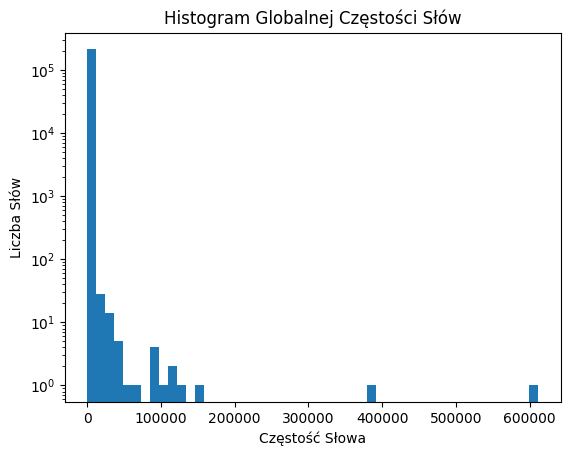

In [126]:
import matplotlib.pyplot as plt

# Wyświetl histogram ilości wystąpień słów
plt.hist(df_global_frequencies['Global_Frequency'], bins=50, log=True)
plt.title('Histogram Globalnej Częstości Słów')
plt.xlabel('Częstość Słowa')
plt.ylabel('Liczba Słów')
plt.show()


In [142]:
# Przefiltruj tokeny o długości większej niż 3 znaki
filtered_tokens = df_global_frequencies[df_global_frequencies['Token'].apply(lambda x: len(x) > 3)]

# Wyświetl 10 najczęściej występujących tokenów
top_long_tokens = filtered_tokens.nlargest(10, 'Global_Frequency')
print(top_long_tokens)


        Token  Global_Frequency
104      jest             88954
107     jeśli             28087
81      które             23933
30       może             23907
630     Jeśli             23816
343      tego             21809
15     możesz             18618
361     przez             17495
337  ponieważ             16466
325     tylko             16461


In [143]:
# Wyświetl statystyki podsumowujące
print(df_global_frequencies['Global_Frequency'].describe())

count    214653.000000
mean         37.344635
std        1773.488767
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max      611385.000000
Name: Global_Frequency, dtype: float64


Z naszego zbioru tokenów nie zostały usunięte znaki interpunkcyjne, dlatego kropka i przecinek przodują one w ilośći wystąpień globalnych. Poza nimi najczęściej występującymi słowami są słowa krótkie, głównie spójniki. Średnia liczba wystąpień słów to 37, jednak należy wziąć pod uwagę kropkę i przecinek, które mogą mocno zaburzać te wartości. Rozkład częstości występowania tokenów jest skośny prawostronnie. Najwięcej jest słów o mniejszych ilościach ich wystapień.

### The performance of your method compared to ElasticSearch,
### The results provided by your method compared to ElasticSearch,
### The validity of the obtained corrections

Podsumowanie wynikód ndcg dla k=10:

- ndcg z błędami: ('NDCG: 116.57975043070748', 'Mean NDCG: 0.1799070222696103')

- ndcg zapytań poprawionych leveshteinem: ('NDCG: 126.67054350343794', 'Mean NDCG: 0.19547923380160176')

- ndcg zapytań poprawionych ES z fuzziness: ('NDCG: 123.48044853830088', 'Mean NDCG: 0.19055624774429147')

Jak widać obie metody poprawy zniekształconych słów spowodowały wzrost wartości ndcg. Wzrost ten nie jest jednak ogromny, lecz o około 1,2 punkty procentowe. Najwyższe ndcg osiągnęły queries poprawione leveshteinem. W tym przypadku  ciężko jest stwierdzić czy któraś metoda jest jednoznacznie lepsza. Można by spróbować w puścić wiele razy "psucie" słów i ich "naprawianie" oraz wtedy uśrednić wyniki i spróbować wyciągnąć wnioski. Niestety zarówno wyszukiwanie słów morfeuszem jak i naprawa ich ES zajmuje dużo czasu, dlatego wyniki pozostawione są dla 1 iteracji.

kilka przykładów:

In [150]:
df_queries[['text', 'distorted_word', 'corrected_text_es',  'corrected_text_Levenshtein']].head(10)

,text,distorted_word,corrected_text_es,corrected_text_Levenshtein
0,Co jest uważane za wydatek służbowy w podróży ...,podroży,Co jest uważane za wydatek służbowy w podróży ...,Co jest uważane za wydatek służbowy w podroży ...
1,Wydatki służbowe - ubezpieczenie samochodu pod...,ya,Wydatki służbowe - ubezpieczenie samochodu pod...,Wydatki służbowe - ubezpieczenie samochodu pod...
2,Rozpoczęcie nowego biznesu online,bianesu,Rozpoczęcie nowego biznesu online,Rozpoczęcie nowego biznesu online
3,„Dzień roboczy” i „termin płatności” rachunków,roboqzy”,„Dzień roboczy” i „termin płatności” rachunków,„Dzień roboczy” i „termin płatności” rachunków
4,Nowy właściciel firmy – Jak działają podatki d...,podatkz,Nowy właściciel firmy – Jak działają podatki d...,Nowy właściciel firmy – Jak działają podatki d...
5,Hobby kontra biznes,konxra,Hobby kontra biznes,Hobby kontra biznes
6,Czeki osobiste zamiast firmowych,osobizte,Czeki osobiste zamiast firmowych,Czeki osobiste zamiast firmowych
7,"Czy amerykański kodeks podatkowy wymaga, aby w...",docród,"Czy amerykański kodeks podatkowy wymaga, aby w...","Czy amerykański kodeks podatkowy wymaga, aby w..."
8,Jak mogę zarejestrować firmę w Wielkiej Brytan...,firmyk,Jak mogę zarejestrować firmę w Wielkiej Brytan...,Jak mogę zarejestrować firmę w Wielkiej Brytan...
9,Czym są „podstawy biznesowe”?,bą,Automatyzacja zdecydowanie zamyka lukę kosztow...,Czym są „podstawy biznesowe”?


In [149]:
df_queries[['text', 'distorted_word', 'corrected_text_es',  'corrected_text_Levenshtein']][2560:2570]

,text,distorted_word,corrected_text_es,corrected_text_Levenshtein
2560,Internetowe oprogramowanie do finansów osobist...,"osobisgych,",Internetowe oprogramowanie do finansów osobist...,Internetowe oprogramowanie do finansów osobist...
2561,Najlepsza strategia finansów osobistych do kon...,stqategia,Najlepsza strategia finansów osobistych do kon...,Najlepsza strategia finansów osobistych do kon...
2562,Różnice w symbolach tickera między Yahoo Finan...,eóżnice,Różnice w symbolach tickera między Yahoo Finan...,różnice w symbolach tickera między Yahoo Finan...
2563,Jak czytać dane Google Finance dotyczące dywidend,czyttć,Jak czytać dane Google Finance dotyczące dywidend,Jak czytać dane Google Finance dotyczące dywidend
2564,Jakie jest znaczenie realizacji w finansach?,w,Jakie jest znaczenie realizacji w finansach?,Jakie jest znaczenie realizacji w finansach?
2565,Oprogramowanie do obsługi finansów osobistych ...,di,Oprogramowanie do obsługi finansów osobistych ...,Oprogramowanie di obsługi finansów osobistych ...
2566,"Bezpłatne, internetowe śledzenie finansów z ob...",śledzenve,"Bezpłatne, internetowe śledzenie finansów z ob...","Bezpłatne, internetowe śledzenie finansów z ob..."
2567,Jak sfinansować swoją strategię handlową w han...,sflnansować,Jak sfinansować swoją strategię handlową w han...,Jak sfinansować swoją strategię handlową w han...
2568,Finansowanie edukacji za pomocą karty kredytow...,studetckich,Finansowanie edukacji za pomocą karty kredytow...,Finansowanie edukacji za pomocą karty kredytow...
2569,"Czy mogę polegać na kapitale własnym, aby sfin...",polegai,"Czy mogę polegać na kapitale własnym, aby sfin...","Czy mogę polegać na kapitale własnym, aby sfin..."


In [151]:
df_queries[['text', 'distorted_word', 'corrected_text_es',  'corrected_text_Levenshtein']][4863:4873]

,text,distorted_word,corrected_text_es,corrected_text_Levenshtein
4863,Jaka jest dobra cena za „wyrzucenie” objętego ...,jnst,Jaka jest dobra cena za „wyrzucenie” objętego ...,Jaka jest dobra cena za „wyrzucenie” objętego ...
4864,Co mam zrobić z oświadczeniami dla pełnomocników?,lla,Co mam zrobić z oświadczeniami dla pełnomocników?,Co mam zrobić z oświadczeniami dla pełnomocników?
4865,"Jaka jest maksymalna liczba opcji, które mogę ...","olcji,",Zaokrąglanie powinno być zawsze zgodne z tą sa...,"Jaka jest maksymalna liczba opcji, które mogę ..."
4866,Dlaczego cena akcji firmy wpływa na jej zdolno...,długh?,Dlaczego cena akcji firmy wpływa na jej zdolno...,Dlaczego cena akcji firmy wpływa na jej zdolno...
4867,Dlaczego liczba wyemitowanych akcji jest mniej...,afcji,Dlaczego liczba wyemitowanych akcji jest mniej...,Dlaczego liczba wyemitowanych akcji jest mniej...
4868,Jak mogę generować 250 USD miesięcznie z 4000 ...,"UiD,",Jak mogę generować 250 USD miesięcznie z 4000 ...,Jak mogę generować 250 USD miesięcznie z 4000 ...
4869,Jak inwestować na japońskiej giełdzie z Wielki...,Wielklej,Jak inwestować na japońskiej giełdzie z Wielki...,Jak inwestować na japońskiej giełdzie z Wielki...
4870,Co się stało z akcjami GOOG? Dlaczego nie jest...,iest,Co się stało z akcjami GOOG? Dlaczego nie jest...,Co się stało z akcjami GOOG? Dlaczego nie jest...
4871,Czy ETF może zostać otwarty po cenie innej niż...,viż,Czy ETF może zostać otwarty po cenie innej niż...,Czy ETF może zostać otwarty po cenie innej niż...
4872,Jak sprawdzić ilość akcji uprzywilejowanych Co...,sxrawdzić,Jak sprawdzić ilość akcji uprzywilejowanych Co...,Jak sprawdzić ilość akcji uprzywilejowanych Co...
